Part A

In [101]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

dataset = pd.read_csv('/content/LINTHALL.txt', delim_whitespace=True, header=None, names=['Index', 'Loc', 'Type', 'BIO', 'H2S', 'SAL', 'Eh7', 'pH', 'BUF', 'P', 'K', 'Ca', 'Mg', 'Na', 'Mn', 'Zn', 'Cu', 'NH4'])

# Droping unnecessary columns
dataset = dataset[['BIO', 'H2S', 'SAL', 'Eh7', 'pH', 'BUF', 'P', 'K', 'Ca', 'Mg', 'Na', 'Mn', 'Zn', 'Cu', 'NH4']]

# Converting object data types to numeric type
dataset[['BIO', 'H2S', 'SAL', 'Eh7', 'pH', 'BUF', 'P', 'K', 'Ca', 'Mg', 'Na', 'Mn', 'Zn', 'Cu', 'NH4']] = dataset[['BIO', 'H2S', 'SAL', 'Eh7', 'pH', 'BUF', 'P', 'K', 'Ca', 'Mg', 'Na', 'Mn', 'Zn', 'Cu', 'NH4']].apply(pd.to_numeric, errors='coerce')

# Droping rows with missing values
dataset = dataset.dropna()

# Model Building
X = dataset[['H2S', 'SAL', 'Eh7', 'pH', 'BUF', 'P', 'K', 'Ca', 'Mg', 'Na', 'Mn', 'Zn', 'Cu', 'NH4']]
y = dataset['BIO']


In [102]:
# Adding a constant term for the intercept
X_const = sm.add_constant(X)

# Fitting the ordinary least squares (OLS) model
model = sm.OLS(y, X_const).fit()

# Model Sumary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    BIO   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     9.270
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           4.03e-07
Time:                        02:33:48   Log-Likelihood:                -302.70
No. Observations:                  43   AIC:                             635.4
Df Residuals:                      28   BIC:                             661.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3475.9507   3441.050      1.010      0.3

In [103]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factor (VIF):")
print(vif_data)

# Checking high VIF values
high_vif_variables = vif_data[vif_data["VIF"] > 5]["Variable"].tolist()
if high_vif_variables:
    print(f"\n High VIF values detected for variables: {', '.join(high_vif_variables)}")

# Checking for condition number
condition_number = np.linalg.cond(X.values)
print(f"\nCondition Number: {condition_number}")

# Checking for a high condition number
if condition_number > 30:
    print("\nHigh condition number detected. Possiblty of multicollinearity.")

Variance Inflation Factor (VIF):
   Variable         VIF
0       H2S  540.841903
1       SAL  132.939848
2       Eh7  132.556078
3        pH  264.512175
4       BUF   69.232763
5         P    7.862896
6         K   54.884722
7        Ca   24.330203
8        Mg  267.346959
9        Na   66.956290
10       Mn   11.662141
11       Zn   67.820281
12       Cu   73.925004
13      NH4   31.573602

 High VIF values detected for variables: H2S, SAL, Eh7, pH, BUF, P, K, Ca, Mg, Na, Mn, Zn, Cu, NH4

Condition Number: 68358.41938487656

High condition number detected. Possiblty of multicollinearity.


Part B

In [104]:
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_var_ratio >= 0.95) + 1

X_selected = X_pca[:, :num_components]
X_selected = sm.add_constant(X_selected)

# Fitting (OLS) model
model_pcr = sm.OLS(y, X_selected).fit()
print(model_pcr.summary())

# Extract the principal component loadings
l = pca.components_[:num_components, :].T
se_pcr = model_pcr.bse[1:]

# Compute standard errors in the original model
se = se_pcr * np.sqrt(np.sum(l**2, axis=0))

# Print the results
print("\nStandard Errors in the Original Model:")
print(se)

# Compare SSE with Part I
sse_pcr = np.sum(model_pcr.resid**2)
print(f"\nSum of Squared Errors (SSE) in PCR Model: {sse_pcr}")

# Assuming 'model' is the OLS model from Part I
sse_ols = np.sum(model.resid**2)
print(f"Sum of Squared Errors (SSE) in Part I: {sse_ols}")

                            OLS Regression Results                            
Dep. Variable:                    BIO   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     12.55
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           3.58e-08
Time:                        02:33:51   Log-Likelihood:                -310.32
No. Observations:                  43   AIC:                             638.6
Df Residuals:                      34   BIC:                             654.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        991.7209     56.525     17.545      0.0

In [105]:
num_components

8

Part C

1.

In [106]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd


X = data[['SAL', 'pH', 'K', 'Na', 'Zn']]
y = data['BIO']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)


model = LinearRegression()
sfs = SequentialFeatureSelector(model, forward=True, k_features='best', scoring='r2', cv=5)
sfs.fit(X_train, y_train)

# Selected feature indices
selected_indices = list(sfs.k_feature_idx_)

# Display the result and regression summary at each step
for step in range(1, len(selected_indices) + 1):
    included_feature = X.columns[selected_indices[step - 1]]
    print(f"\nStep {step}: {included_feature} added to the model")

    # Fit the model with the selected features
    partial_model = LinearRegression().fit(X_train.iloc[:, selected_indices[:step]], y_train)

    # Display the regression summary
    print("\nPartial Model Summary:")
    print(pd.DataFrame({'Variable': X.columns[selected_indices[:step]], 'Coefficient': partial_model.coef_}))
    print(f"R-squared on the training set: {partial_model.score(X_train.iloc[:, selected_indices[:step]], y_train)}")

# Fit the final model with the selected features
final_model = LinearRegression().fit(X_train.iloc[:, selected_indices], y_train)

# Display the coefficients of the final model
print("\nCoefficients after Stepwise Regression:")
print(pd.DataFrame({'Variable': X.columns[selected_indices], 'Coefficient': final_model.coef_}))

# Evaluate the final model on the test set
final_model_score = final_model.score(X_test.iloc[:, selected_indices], y_test)
print(f"\nR-squared on the test set for the final model: {final_model_score}")



Step 1: pH added to the model

Partial Model Summary:
  Variable  Coefficient
0       pH   362.664982
R-squared on the training set: 0.47824436495643585

Step 2: Na added to the model

Partial Model Summary:
  Variable  Coefficient
0       pH   371.835420
1       Na    -0.020561
R-squared on the training set: 0.5366045317617536

Coefficients after Stepwise Regression:
  Variable  Coefficient
0       pH   371.835420
1       Na    -0.020561

R-squared on the test set for the final model: 0.8678878926209593


In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data

# Display VIF for the final selected features
vif_final_model = calculate_vif(X_train.iloc[:, selected_indices])
print("\nVIF Values for the Final Model:")
print(vif_final_model)

# Check if there is significant multicollinearity
if all(vif_final_model["VIF"] < 10):
    print("\nThere is no significant multicollinearity in the final model.")
else:
    print("\nMulticollinearity is present in the final model. Consider further investigation.")



VIF Values for the Final Model:
  Variable       VIF
0       pH  5.392122
1       Na  5.392122

There is no significant multicollinearity in the final model.


2.

Ridge Trace:
             Alpha         CV_MSE
0         0.000001  184039.533707
1         0.000010  184039.506122
2         0.000100  184039.230279
3         0.001000  184036.472578
4         0.010000  184008.967802
5         0.100000  183740.944616
6         1.000000  181613.423435
7        10.000000  178600.163499
8       100.000000  272801.058463
9      1000.000000  416737.992603
10    10000.000000  446451.321466
11   100000.000000  449719.685767
12  1000000.000000  450049.764103

Alpha Selected: 10.0

Coefficients after Ridge Regression:
[ -88.782382    298.9606666   -60.86999177  -63.95162596 -182.67008386]
  Variable       VIF
0      SAL  2.099364
1       pH  3.327339
2        K  2.982513
3       Na  3.311625
4       Zn  4.309322

There is no significant multicollinearity, and collinearity has disappeared.


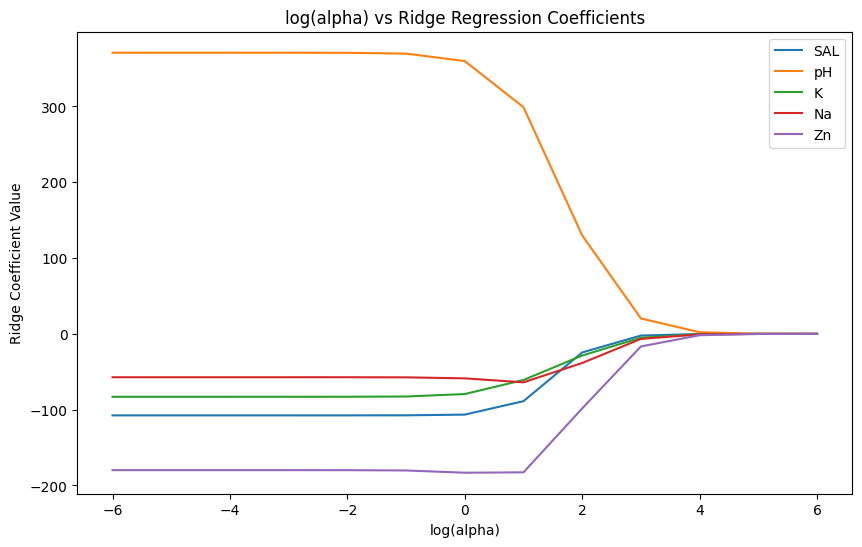

In [108]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt


X = dataset_2[['SAL', 'pH', 'K', 'Na', 'Zn']]
y = dataset_2['BIO']
coefficients = []

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


alphas = np.logspace(-6, 6, 13)
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_scaled, y)


selected_alpha = ridge_cv.alpha_
cv_mse = np.mean(ridge_cv.cv_values_, axis=0)
ridge_trace = pd.DataFrame({'Alpha': alphas, 'CV_MSE': cv_mse})
print("Ridge Trace:")
print(ridge_trace)
print("\nAlpha Selected:", selected_alpha)

# Fitting Ridge model with the selected alpha
final_ridge_model = RidgeCV(alphas=[selected_alpha])
final_ridge_model.fit(X_scaled, y)

# Print coefficients of the final Ridge model
print("\nCoefficients after Ridge Regression:")
print(final_ridge_model.coef_)

# Perform collinearity diagnostics
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print(vif_data)

threshold = 10
if vif_data["VIF"].max() < threshold:
    print("\nThere is no significant multicollinearity, and collinearity has disappeared.")
else:
    print("\nThere is potential multicollinearity in the model.")

for alpha in alphas:
    ridge_model = RidgeCV(alphas=[alpha], store_cv_values=True)
    ridge_model.fit(X_scaled, y)
    coefficients.append(ridge_model.coef_)

coefficients = np.array(coefficients)

# Plot log(alpha) versus Ridge regression coefficients
plt.figure(figsize=(10, 6))
for i in range(X.shape[1]):
    plt.plot(np.log10(alphas), coefficients[:, i], label=f'{X.columns[i]}')

plt.xlabel('log(alpha)')
plt.ylabel('Ridge Coefficient Value')
plt.title('log(alpha) vs Ridge Regression Coefficients')
plt.legend()
plt.show()

3.

In [114]:
from sklearn.linear_model import LinearRegression
from itertools import combinations
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Extract predictor variables (X) and response variable (Y)
X_part3 = dataset_2[['SAL', 'pH', 'K', 'Na', 'Zn']]
Y_part3 = dataset_2['BIO']

# BIC
def calculate_bic(X, Y, features):
    model = sm.OLS(Y, sm.add_constant(X[features])).fit()
    n = len(Y)
    k = len(features) + 1  # Including the intercept term
    bic = n * np.log(model.mse_resid) + k * np.log(n)
    return bic

# Performing subset selection
def subset_selection(X, Y, max_features=2):
    af = X.columns
    best_bic = float('inf')
    best_feature_subset = None

    for r in range(1, max_features + 1):
        for subset in combinations(af, r):
            bic = calculate_bic(X, Y, list(subset))
            if bic < best_bic:
                best_bic = bic
                best_feature_subset = subset

    return list(best_feature_subset)


selected_features_subset = subset_selection(X_part3, Y_part3, max_features=2)
print("Selected Features (Subset Selection):", selected_features_subset)

# Check VIF for the selected features
selected_features_vif = sm.add_constant(X_part3[selected_features_subset])
vif = pd.DataFrame()
vif["Variable"] = selected_features_vif.columns
vif["VIF"] = [variance_inflation_factor(selected_features_vif.values, i) for i in range(selected_features_vif.shape[1])]

# Display VIF values
print("VIF Values:")
print(vif)

Selected Features (Subset Selection): ['pH', 'Na']
VIF Values:
  Variable        VIF
0    const  20.746465
1       pH   1.000558
2       Na   1.000558


In [115]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BIO   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     15.74
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           9.07e-06
Time:                        02:43:18   Log-Likelihood:                -327.39
No. Observations:                  43   AIC:                             660.8
Df Residuals:                      40   BIC:                             666.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2139.2998    248.072      8.624      0.000    1637.927    2640.673
Na            -0.0173      0.011     -1.535      0.133      -0.040       0.005
Zn           -48.3377      9.351     -5.170      0.000     -67.236     -29.440
==============================================================================
Omnibus:                        5.749   Durbin-Watson:                   0.844
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                4.759
Skew:                           0.798   Prob(JB):                       0.0926
Kurtosis:                       3.331   Cond. No.                     5.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""